`63070501061 S.RAKNA`

> 20 points, 1 hr.

# CNN on MNIST

- Change the `CNN MNIST` Google Colab to have 
  - 2 Convolutional layers 
  - before flattening instead of just 1. 
  - Also, add a softmax layer to the end. 
- Run for 5 epochs. 
- Show the confusion matrix for the test data. 
- What is your test accuracy?

In [1]:
# Import TensorFlow

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0-rc0


In [2]:
# Load and prepare the MNIST dataset. Convert the samples from integers to floating-point numbers:

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("double")
x_test = x_test[..., tf.newaxis].astype("double")

In [3]:
# Use tf.data to batch and shuffle the dataset

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [4]:
# Build the tf.keras model using the Keras model subclassing API

class ModelCustom(Model):
    def __init__(self):
        super(ModelCustom, self).__init__()
        '''
        - 2 Convolutional layers 
        - before flattening instead of just 1. 
        - Also, add a softmax layer to the end. 
        '''
        # 2 Convolutional layers
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.conv2 = Conv2D(64, 3, activation='relu')
        # before flattening instead of just 1.
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        # Also, add a softmax layer to the end.
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = ModelCustom()

In [5]:
# Choose an optimizer and loss function for training:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.legacy.Adam()

In [6]:
# Select metrics to measure the loss and the accuracy of the model.
# These metrics accumulate the values over epochs and then print the overall result.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')

In [7]:
# Use tf.GradientTape to train the model:

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [8]:
# Test the model:

@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [9]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

2023-05-26 16:54:22.687193: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2023-05-26 16:54:22.687352: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2023-05-26 16:54:58.387724: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000

Epoch 1, Loss: 0.10697178542613983, Accuracy: 96.7750015258789, Test Loss: 0.05085676908493042, Test Accuracy: 98.3699951171875
Epoch 2, Loss: 0.03586111590266228, Accuracy: 98.87333679199219, Test Loss: 0.03529967740178108, Test Accuracy: 98.79000091552734
Epoch 3, Loss: 0.01934266835451126, Accuracy: 99.3883285522461, Test Loss: 0.043109744787216187, Test Accuracy: 98.80999755859375
Epoch 4, Loss: 0.013640823774039745, Accuracy: 99.55500030517578, Test Loss: 0.04217495769262314, Test Accuracy: 98.9000015258789
Epoch 5, Loss: 0.009999570436775684, Accuracy: 99.65833282470703, Test Loss: 0.06160704419016838, Test Accuracy: 98.5


In [10]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations 
Y_true = y_test.reshape(-1, 1)

313/313 [==============================] - 2s 6ms/step


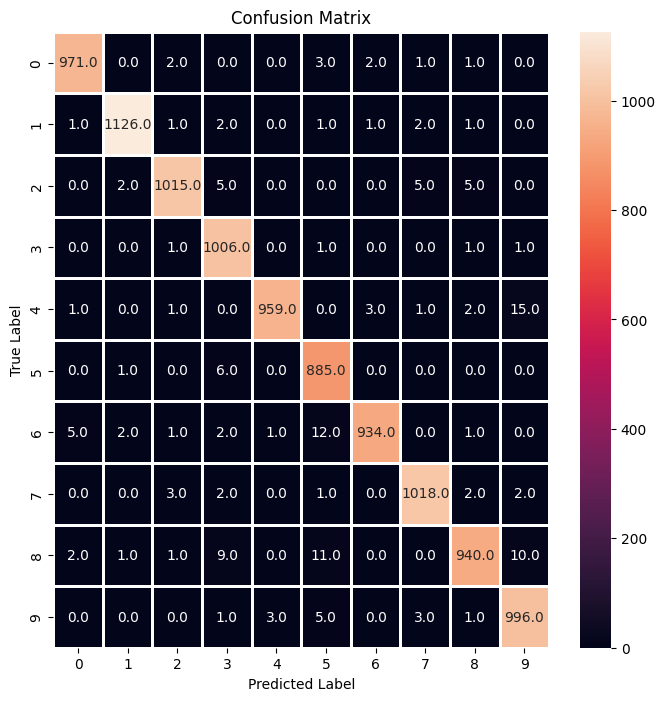

In [11]:
# Confusion Matrix for the test data

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    confusion_mtx,
    annot=True,
    linewidths=1,
    fmt=".1f",
    ax=ax
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Report the accuracy of the model

from sklearn.metrics import accuracy_score

print(f'Accuracy: {accuracy_score(Y_true, Y_pred_classes)}')

Accuracy: 0.985
